In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Import some useful packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

#### Layers for FNN

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

#### Optimizers for training

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

#### Losses for training

In [6]:
from tensorflow.keras import losses

#### For data preprocessing

In [7]:
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

### 匯入MNIST 資料集

In [8]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

### 建立ＶＡＥ模型

In [9]:
model_encoder_1 = Dense(512, activation='sigmoid')
model_encoder_2 = Dense(100, activation='sigmoid')

model_encoder_mean = Dense(2)
model_encoder_log_var = Dense(2)

model_decoder_3 = Dense(100, activation='sigmoid')
model_decoder_2 = Dense(512, activation='sigmoid')
model_decoder_1 = Dense(784, activation='sigmoid')

In [10]:
x = Input(shape=(784,))
model_encoder_x = model_encoder_2(model_encoder_1(x))

z_mean = model_encoder_mean(model_encoder_x)
z_log_var = model_encoder_log_var(model_encoder_x)

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [13]:
z_input = Input(shape=(2,))
x_hat = model_decoder_1(model_decoder_2(model_decoder_3(z_input)))

In [14]:
x_hat = model_decoder_1(model_decoder_2(model_decoder_3((z))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          51300       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
______________________________________________________________________________________________

### 展示結果

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 453,422
Trainable params: 453,422
Non-trainable params: 0
_________________________________________________________________


In [16]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

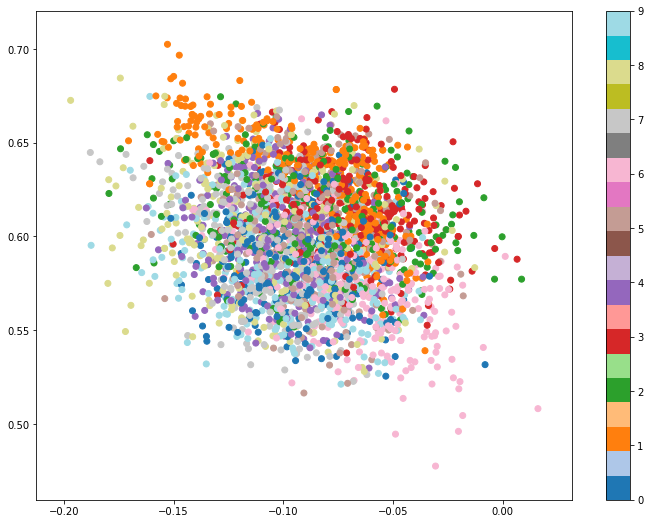

In [21]:
plt.figure(figsize=(12, 9))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [22]:
VAE_Decoder = Model(z_input, model_decoder_1(model_decoder_2(model_decoder_3(z_input))))

VAE_Decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 454,204
Trainable params: 454,204
Non-trainable params: 0
_________________________________________________________________


In [23]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [24]:
n = 20
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

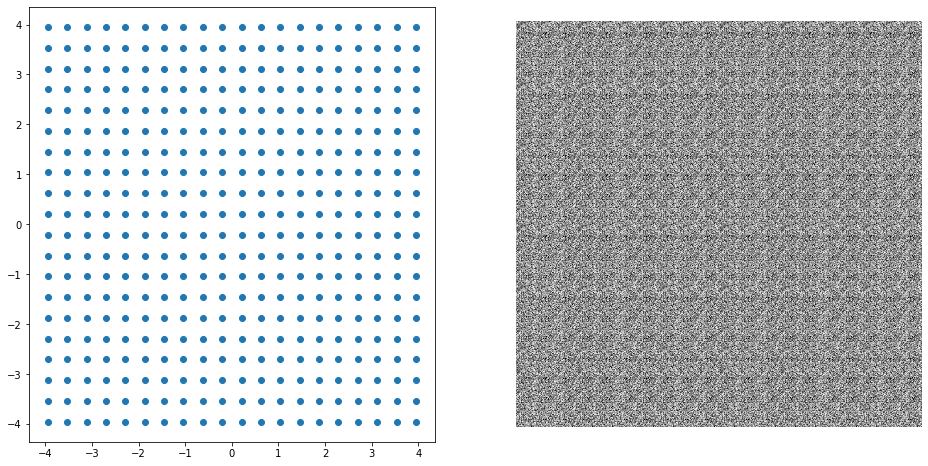

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()